In [218]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

1.4.1.post1


## Loading the data

In [219]:
# weather data
weather = pd.read_csv('data/weather.csv')
weather.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,50.0,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,2023-02-28T23:00:00,NaN,NaN,4.6,NaN,NaN,NaN,...,1,37.9,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,19.2,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,2023-02-28T23:00:00,NaN,NaN,-2.6,NaN,NaN,NaN,...,1,23.6,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T00:00:00,0.0,1.0,-0.5,NaN,NaN,NaN,...,1,27.9,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN


In [220]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.head()

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [221]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


## Take a quick look at the data structure of every data set

### weather

In [222]:
weather.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,50.0,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,2023-02-28T23:00:00,NaN,NaN,4.6,NaN,NaN,NaN,...,1,37.9,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,19.2,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,2023-02-28T23:00:00,NaN,NaN,-2.6,NaN,NaN,NaN,...,1,23.6,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T00:00:00,0.0,1.0,-0.5,NaN,NaN,NaN,...,1,27.9,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN


Observation:
- one row in every four rows in the data set represents the measurements of one weahter station at one timestamp

In [223]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32808 entries, 0 to 32807
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          32808 non-null  object 
 1   the_geom                     32808 non-null  object 
 2   code                         32808 non-null  int64  
 3   timestamp                    32808 non-null  object 
 4   precip_quantity              5331 non-null   float64
 5   precip_range                 5443 non-null   float64
 6   temp                         32808 non-null  float64
 7   temp_min                     1368 non-null   float64
 8   temp_max                     1361 non-null   float64
 9   temp_grass_min               1020 non-null   float64
 10  wind_speed                   32795 non-null  float64
 11  wind_speed_unit              32808 non-null  int64  
 12  wind_direction               32419 non-null  float64
 13  wind_peak_speed 

Observation:
- There are a lot of attributes with a lot of null-values

In [224]:
weather["the_geom"].value_counts()

POINT (51.200341 2.887306)    8202
POINT (51.347375 3.201846)    8202
POINT (50.90398 3.121692)     8202
POINT (50.980293 3.816003)    8202
Name: the_geom, dtype: int64

In [225]:
weather["code"].value_counts()

6407    8202
6418    8202
6414    8202
6434    8202
Name: code, dtype: int64

Observation:
- the_geom and code both specify the weather station

In [226]:
# count the amount of cloudiness vlaues per code
weather[["code", "cloudiness"]].groupby("code").count()

,cloudiness
code,
6407,8123
6414,0
6418,3986
6434,0


Observation:
- only weather stations 6407 and 6418 have measured cloudiness values

In [227]:
weather.describe()

,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
count,32808.000000,5331.000000,5443.000000,32808.000000,1368.000000,1361.000000,1020.000000,32795.000000,32808.0,32419.000000,32787.000000,24606.000000,2238.000000,32796.000000,32808.000000,1026.000000,6.840000e+02,12109.000000
mean,6418.250000,0.954305,1.499724,12.329776,9.408187,15.649155,6.926569,4.846273,1.0,187.127802,8.399823,80.474157,37.555407,1014.276738,1012.431651,343.655945,1.126558e+07,5.321001
std,9.909112,2.537816,0.500046,6.182454,5.232279,6.900909,5.528216,2.694851,0.0,93.419376,4.160065,14.275662,26.591923,10.862153,10.876588,285.087036,8.328554e+06,2.582361
min,6407.000000,0.000000,1.000000,-5.900000,-6.000000,-1.000000,-10.200000,0.000000,1.0,0.100000,0.300000,24.700000,1.000000,965.100000,963.500000,0.000000,4.169000e+05,0.000000
25%,6412.250000,0.000000,1.000000,8.400000,6.300000,10.700000,3.900000,2.901500,1.0,115.500000,5.200000,71.900000,11.000000,1008.300000,1006.500000,68.750000,3.821650e+06,3.000000
50%,6416.000000,0.000000,1.000000,11.900000,9.600000,14.800000,7.100000,4.377000,1.0,207.100000,8.000000,83.600000,25.000000,1015.600000,1013.700000,296.500000,9.624900e+06,7.000000
75%,6422.000000,0.500000,2.000000,16.900000,13.400000,21.100000,11.000000,6.493500,1.0,250.200000,11.000000,91.700000,61.000000,1021.700000,1019.800000,578.750000,1.771668e+07,7.000000
max,6434.000000,43.400000,2.000000,32.400000,23.000000,32.900000,20.500000,21.088000,1.0,360.000000,31.100000,100.000000,100.000000,1041.800000,1040.400000,950.000000,2.943290e+07,8.000000


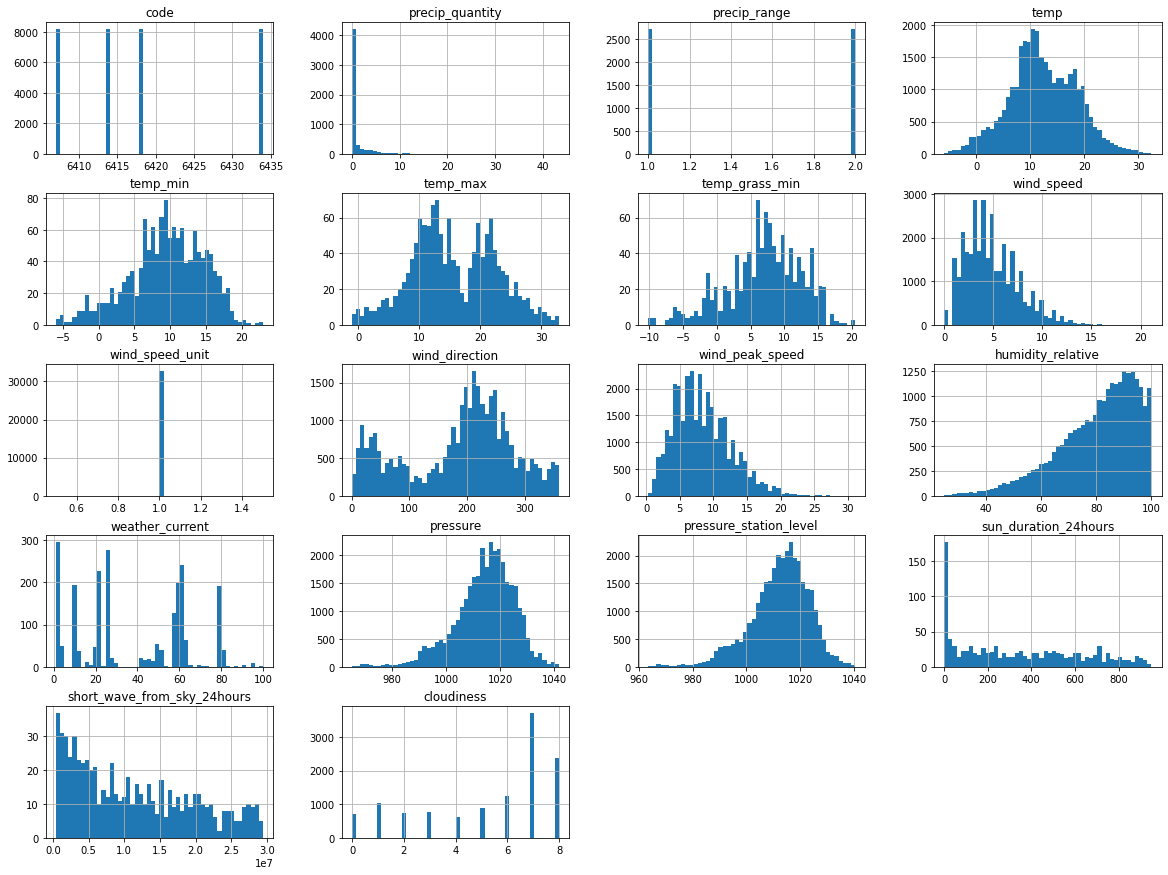

In [228]:
weather.hist(bins=50, figsize=(20,15))
plt.show()

Observations:
- wind_speed_unit has only one value -> not usefull
- code, precip_range, wind_spead and cloudiness are categroical
- precip_ranges only has two values -> not very usefull
- humidity_relative looks capped at 100
- sun_duration_24hours has a heavy tail

### solar

In [229]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7907 non-null   object 
 1   kwh        7907 non-null   float64
dtypes: float64(1), object(1)
memory usage: 123.7+ KB


In [230]:
solar.describe()

,kwh
count,7907.000000
mean,1222.790435
std,707.659230
min,0.000000
25%,547.675800
50%,1444.772000
75%,1897.269400
max,2043.015400


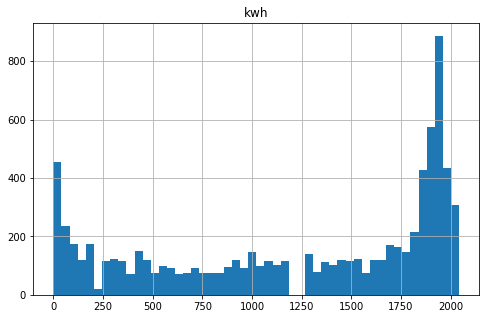

In [231]:
solar.hist(bins=50, figsize=(8, 5))
plt.show()

Observation:
- kwh is a cumulative value

### sunrise-sunset

In [232]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datum           731 non-null    datetime64[ns]
 1   Opkomst         731 non-null    object        
 2   Op ware middag  731 non-null    object        
 3   Ondergang       731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


In [233]:
sun[["Opkomst", "Op ware middag", "Ondergang"]].describe()

,Opkomst,Op ware middag,Ondergang
count,731,731,731
unique,195,56,283
top,05:29:00,13:39:00,16:37:00
freq,24,51,20


## Cleaning the data

### weahter

In [234]:
# drop columns with more than 70% missing values
weather = weather.dropna(thresh=0.3*len(weather), axis=1)
# drop useless columns
weather.drop(columns=["FID", "the_geom", "code", "wind_speed_unit"], axis=1, inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32808 entries, 0 to 32807
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               32808 non-null  object 
 1   temp                    32808 non-null  float64
 2   wind_speed              32795 non-null  float64
 3   wind_direction          32419 non-null  float64
 4   wind_peak_speed         32787 non-null  float64
 5   humidity_relative       24606 non-null  float64
 6   pressure                32796 non-null  float64
 7   pressure_station_level  32808 non-null  float64
 8   cloudiness              12109 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.3+ MB


In [235]:
weather.groupby("timestamp").mean().reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8202 entries, 0 to 8201
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               8202 non-null   object 
 1   temp                    8202 non-null   float64
 2   wind_speed              8202 non-null   float64
 3   wind_direction          8202 non-null   float64
 4   wind_peak_speed         8202 non-null   float64
 5   humidity_relative       8202 non-null   float64
 6   pressure                8202 non-null   float64
 7   pressure_station_level  8202 non-null   float64
 8   cloudiness              8202 non-null   float64
dtypes: float64(8), object(1)
memory usage: 576.8+ KB


In [236]:
# group by timestamp, and take the mean of each group
print(len(weather))
weather = weather.groupby("timestamp").mean().reset_index()
print(len(weather))
weather.head()

32808
8202


,timestamp,temp,wind_speed,wind_direction,wind_peak_speed,humidity_relative,pressure,pressure_station_level,cloudiness
0,2023-02-28T23:00:00,0.350,3.03150,32.675,4.15,70.900000,1031.775,1029.800,0.5
1,2023-03-01T00:00:00,0.850,3.48600,33.450,5.80,69.833333,1031.875,1029.925,0.5
2,2023-03-01T01:00:00,0.450,3.16675,36.475,4.70,74.800000,1031.750,1029.775,0.5
3,2023-03-01T02:00:00,0.725,3.57325,36.175,5.25,78.033333,1031.250,1029.300,0.5
4,2023-03-01T03:00:00,-0.075,3.18425,34.475,5.25,81.600000,1030.625,1028.650,0.5


In [237]:
# clean weather timestamp data
weather["timestamp"] = weather["timestamp"].apply(lambda date: pd.to_datetime(date).strftime("%Y-%m-%d %H"))
# split timestamp into date and hour
weather["date"] = weather["timestamp"].apply(lambda date: date.split(" ")[0])
weather["hour"] = weather["timestamp"].apply(lambda date: date.split(" ")[1])
weather.drop(columns=["timestamp"], inplace=True)
weather.head()

,temp,wind_speed,wind_direction,wind_peak_speed,humidity_relative,pressure,pressure_station_level,cloudiness,date,hour
0,0.350,3.03150,32.675,4.15,70.900000,1031.775,1029.800,0.5,2023-02-28,23
1,0.850,3.48600,33.450,5.80,69.833333,1031.875,1029.925,0.5,2023-03-01,00
2,0.450,3.16675,36.475,4.70,74.800000,1031.750,1029.775,0.5,2023-03-01,01
3,0.725,3.57325,36.175,5.25,78.033333,1031.250,1029.300,0.5,2023-03-01,02
4,-0.075,3.18425,34.475,5.25,81.600000,1030.625,1028.650,0.5,2023-03-01,03


### solar

In [238]:
# make kwn non-cumulative
solar["kwh"] = solar["kwh"] - solar["kwh"].shift(1, fill_value=0)
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,0.48
2,2023-03-11 18:00:10.284064+01,0.15
3,2023-03-11 19:00:10.224836+01,0.01
4,2023-03-11 20:00:10.201847+01,0.00


In [239]:
mean = solar["kwh"].mean()
std = solar["kwh"].std()
print(len(solar))
# remove outliers
solar = solar[abs(solar["kwh"] - mean) < std]
print(len(solar))
solar.describe()

7907
7904


,kwh
count,7904.000000
mean,0.243170
std,0.455937
min,0.000000
25%,0.000000
50%,0.000000
75%,0.238000
max,2.098000


In [240]:
# clean solar timestamp data
solar["timestamp"] = solar["timestamp"].apply(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H"))
# split timestamp into date and huor
solar["date"] = solar["timestamp"].apply(lambda date: date.split(" ")[0])
solar["hour"] = solar["timestamp"].apply(lambda date: date.split(" ")[1])
solar.drop(columns=["timestamp"], inplace=True)
solar.head()

,kwh,date,hour
0,0.54,2023-03-11,16
1,0.48,2023-03-11,17
2,0.15,2023-03-11,18
3,0.01,2023-03-11,19
4,0.00,2023-03-11,20


### sunrise-sunset

In [241]:
sun.rename(columns={"datum": "date", "Opkomst": "sunrise", "Op ware middag": "sun_noon", "Ondergang": "sunset"}, inplace=True)
# make date column a string
sun["date"] = sun["date"].apply(lambda date: date.strftime("%Y-%m-%d"))
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [242]:
# change timestamps to difference in minutes from minimum timestamp
sun["sunrise"] = sun["sunrise"].apply(lambda time: time.hour*60 + time.minute)
sunrise_min = sun["sunrise"].min()
sun["sunrise"] = sun["sunrise"] - sunrise_min

sun["sun_noon"] = sun["sun_noon"].apply(lambda time: time.hour*60 + time.minute)
sun_noon_min = sun["sun_noon"].min()
sun["sun_noon"] = sun["sun_noon"] - sun_noon_min

sun["sunset"] = sun["sunset"].apply(lambda time: time.hour*60 + time.minute)
sunset_min = sun["sunset"].min()
sun["sunset"] = sun["sunset"] - sunset_min
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,196,20,10
1,2023-01-02,196,20,11
2,2023-01-03,196,21,12
3,2023-01-04,195,21,14
4,2023-01-05,195,22,15


### merge all data sets into one

In [243]:
# merge all data
data = weather.merge(solar, on=["date", "hour"], how="inner").merge(sun, on=["date"], how="inner")
print(data.shape)

(7904, 14)


In [244]:
# convert date to datetime
data["date"] = data["date"].astype("datetime64")
# add month and day columns
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.dayofweek
# drop date column
data.drop("date", axis=1, inplace=True)
# convert hour to int
data["hour"] = data["hour"].astype("int")

## Date exploration

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7904 entries, 0 to 7903
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temp                    7904 non-null   float64
 1   wind_speed              7904 non-null   float64
 2   wind_direction          7904 non-null   float64
 3   wind_peak_speed         7904 non-null   float64
 4   humidity_relative       7904 non-null   float64
 5   pressure                7904 non-null   float64
 6   pressure_station_level  7904 non-null   float64
 7   cloudiness              7904 non-null   float64
 8   hour                    7904 non-null   int32  
 9   kwh                     7904 non-null   float64
 10  sunrise                 7904 non-null   int64  
 11  sun_noon                7904 non-null   int64  
 12  sunset                  7904 non-null   int64  
 13  month                   7904 non-null   int64  
 14  day                     7904 non-null   

In [246]:
data.head()

,temp,wind_speed,wind_direction,wind_peak_speed,humidity_relative,pressure,pressure_station_level,cloudiness,hour,kwh,sunrise,sun_noon,sunset,month,day
0,6.30,1.80350,121.10,3.675,57.800000,1011.625,1009.750,7.0,16,0.54,97,27,123,3,5
1,5.95,1.98875,134.70,3.925,60.366667,1011.500,1009.575,7.0,17,0.48,97,27,123,3,5
2,5.25,1.93150,120.45,5.525,64.500000,1011.850,1009.975,7.0,18,0.15,97,27,123,3,5
3,4.85,2.55400,124.85,3.475,68.633333,1011.650,1009.750,7.0,19,0.01,97,27,123,3,5
4,4.90,2.24625,114.00,4.025,68.400000,1011.700,1009.800,7.0,20,0.00,97,27,123,3,5


In [247]:
data.describe()

,temp,wind_speed,wind_direction,wind_peak_speed,humidity_relative,pressure,pressure_station_level,cloudiness,hour,kwh,sunrise,sun_noon,sunset,month,day
count,7904.000000,7904.000000,7904.00000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000,7904.000000
mean,12.572637,4.964538,188.49693,8.574419,80.886901,1013.905273,1012.054384,5.304529,12.015309,0.243170,98.093117,54.670167,177.172444,7.004555,2.977227
std,5.970986,2.336220,82.47841,3.937315,13.078458,11.442767,11.419250,2.410042,7.168911,0.455937,65.511522,29.741276,116.516129,3.325708,1.973566
min,-4.650000,0.261000,6.62500,1.250000,31.366667,967.800000,965.925000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8.650000,3.163750,136.40000,5.575000,73.100000,1008.075000,1006.250000,3.000000,6.000000,0.000000,41.000000,25.000000,41.000000,4.000000,1.000000
50%,12.225000,4.608500,207.38750,7.950000,84.333333,1015.900000,1014.050000,6.500000,12.000000,0.000000,95.000000,73.000000,213.000000,7.000000,3.000000
75%,17.000000,6.503250,250.62500,11.075000,91.533333,1021.700000,1019.850000,7.000000,18.000000,0.238000,163.000000,78.000000,286.000000,10.000000,5.000000
max,30.975000,16.915250,356.97500,28.625000,99.033333,1041.275000,1039.325000,8.000000,23.000000,2.098000,196.000000,83.000000,323.000000,12.000000,6.000000


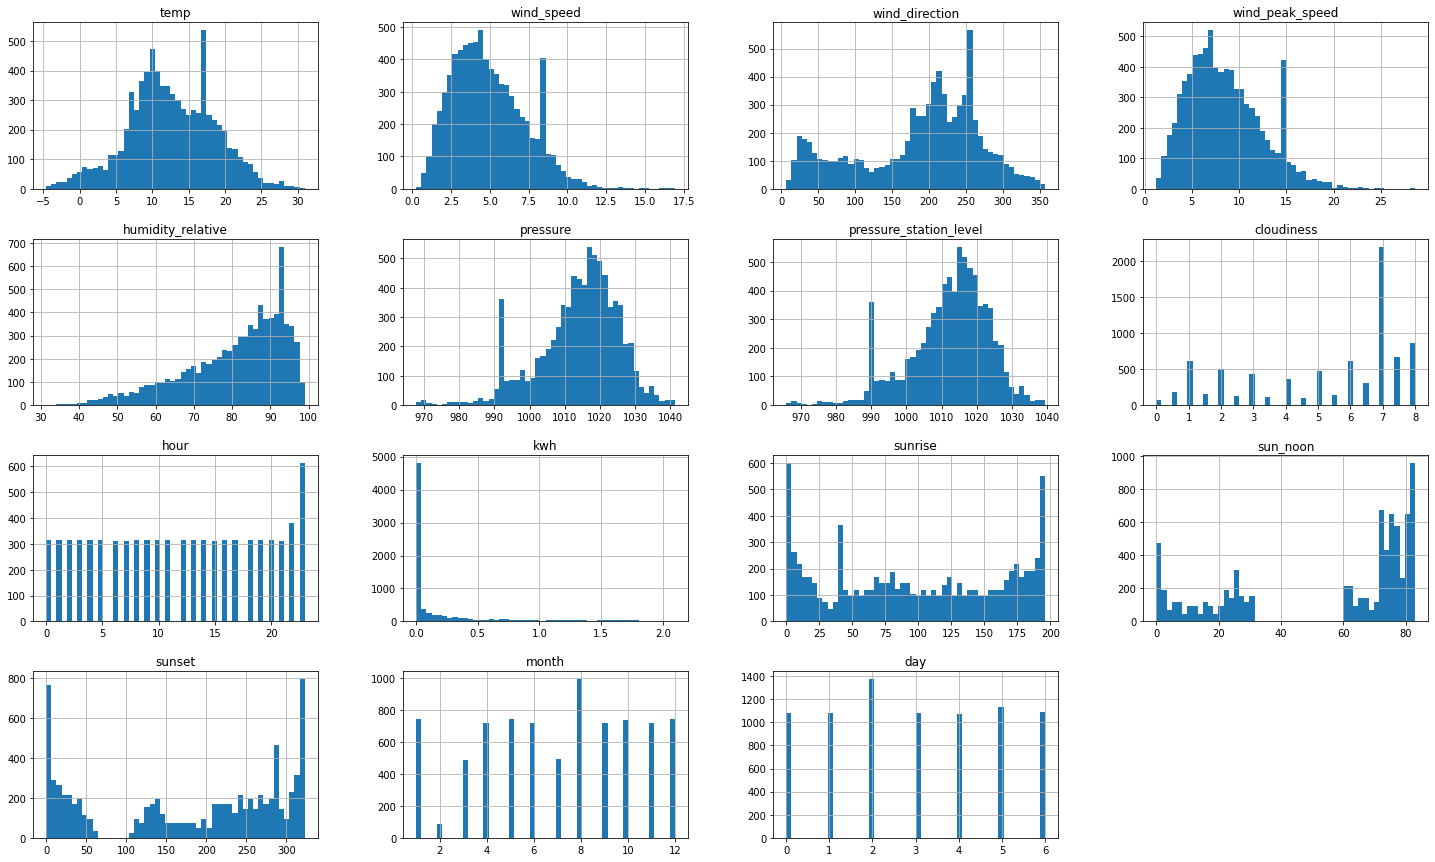

In [248]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

Observations:
- kwh has a very heave tail
- month, day, hour and cloudiness are categorical

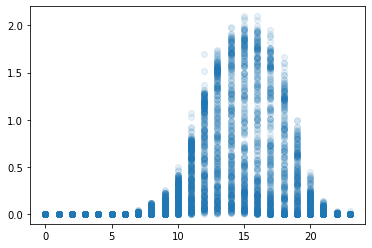

In [249]:
plt.scatter(data["hour"], data["kwh"], alpha=0.1)
plt.show()

Observation:
- kwh is clearly higher during the day

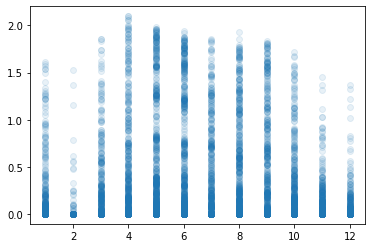

In [250]:
plt.scatter(data["month"], data["kwh"], alpha=0.1)
plt.show()

## Create a test set

In [251]:
X = data.drop(columns=["kwh"])
y = data["kwh"]

In [252]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(6323, 1581)

## Look for correlations

In [253]:
data = pd.concat([X_train, y_train], axis=1)

In [254]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                       1.00
temp                      0.40
sunset                    0.27
sun_noon                  0.24
hour                      0.18
pressure_station_level    0.18
pressure                  0.18
wind_speed                0.05
wind_peak_speed           0.05
day                       0.00
month                    -0.09
wind_direction           -0.10
sunrise                  -0.26
cloudiness               -0.27
humidity_relative        -0.68
Name: kwh, dtype: float64

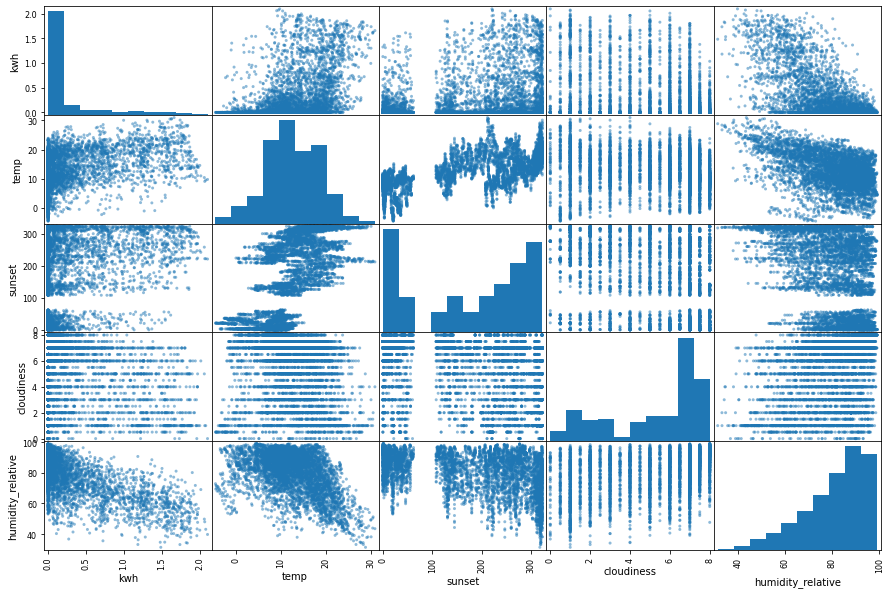

In [257]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "temp", "sunset", "cloudiness", "humidity_relative"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()

## Prepare the data

In [258]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6323 entries, 4877 to 7270
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temp                    6323 non-null   float64
 1   wind_speed              6323 non-null   float64
 2   wind_direction          6323 non-null   float64
 3   wind_peak_speed         6323 non-null   float64
 4   humidity_relative       6323 non-null   float64
 5   pressure                6323 non-null   float64
 6   pressure_station_level  6323 non-null   float64
 7   cloudiness              6323 non-null   float64
 8   hour                    6323 non-null   int32  
 9   sunrise                 6323 non-null   int64  
 10  sun_noon                6323 non-null   int64  
 11  sunset                  6323 non-null   int64  
 12  month                   6323 non-null   int64  
 13  day                     6323 non-null   int64  
dtypes: float64(8), int32(1), int64(5)
mem

In [260]:
# give categorical values their own type
X_train["month"] = X_train["month"].astype("category")
X_train["day"] = X_train["day"].astype("category")
X_train["hour"] = X_train["hour"].astype("category")
X_train["cloudiness"] = X_train["cloudiness"].astype("category")

In [265]:
data_num_ix = X_train.select_dtypes(include=[np.number]).columns
data_cat_ix = X_train.select_dtypes(include=["category"]).columns
print("Numerical columns: ", data_num_ix)
print("Categorical columns: ", data_cat_ix)

Numerical columns:  Index(['temp', 'wind_speed', 'wind_direction', 'wind_peak_speed',
       'humidity_relative', 'pressure', 'pressure_station_level', 'sunrise',
       'sun_noon', 'sunset'],
      dtype='object')
Categorical columns:  Index(['cloudiness', 'hour', 'month', 'day'], dtype='object')


In [257]:
# work in progress
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeDate(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        # X = check_array(X)
        return self

    def transform(self, X):
        assert "date" in self.feature_names_in_
        X = X.copy()
        X["date"] = pd.to_datetime(X["date"])
        X["month"] = X["date"].dt.month
        X["day"] = X["date"].dt.dayofweek
        X["month"] = X["month"].astype("category")
        X["day"] = X["day"].astype("category")
        X.drop("date", axis=1, inplace=True)
        return X

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# log_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("log", FunctionTransformer(np.log, inverse_func=np.exp)),
#     ("standardize", StandardScaler())
# ])

cat_pipline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")), 
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, data_num_ix),
    ("cat", cat_pipline, data_cat_ix)
])

In [23]:
X_train_prepared = preprocessing.fit_transform(X_train)
X_train_prepared.shape

(25292, 63)

In [24]:
preprocessing.get_feature_names_out()

array(['num__temp', 'num__wind_speed', 'num__wind_direction',
       'num__wind_peak_speed', 'num__humidity_relative', 'num__pressure',
       'num__pressure_station_level', 'cat__code_6407.0',
       'cat__code_6414.0', 'cat__code_6418.0', 'cat__code_6434.0',
       'cat__cloudiness_0.0', 'cat__cloudiness_1.0',
       'cat__cloudiness_2.0', 'cat__cloudiness_3.0',
       'cat__cloudiness_4.0', 'cat__cloudiness_5.0',
       'cat__cloudiness_6.0', 'cat__cloudiness_7.0',
       'cat__cloudiness_8.0', 'cat__hour_0.0', 'cat__hour_1.0',
       'cat__hour_2.0', 'cat__hour_3.0', 'cat__hour_4.0', 'cat__hour_5.0',
       'cat__hour_6.0', 'cat__hour_7.0', 'cat__hour_8.0', 'cat__hour_9.0',
       'cat__hour_10.0', 'cat__hour_11.0', 'cat__hour_12.0',
       'cat__hour_13.0', 'cat__hour_14.0', 'cat__hour_15.0',
       'cat__hour_16.0', 'cat__hour_17.0', 'cat__hour_18.0',
       'cat__hour_19.0', 'cat__hour_20.0', 'cat__hour_21.0',
       'cat__hour_22.0', 'cat__hour_23.0', 'cat__month_1.0',
       '

In [25]:
X_train_prepared_df = pd.DataFrame(X_train_prepared.toarray(), columns=preprocessing.get_feature_names_out())
X_train_prepared_df.head()

,num__temp,num__wind_speed,num__wind_direction,num__wind_peak_speed,num__humidity_relative,num__pressure,num__pressure_station_level,cat__code_6407.0,cat__code_6414.0,cat__code_6418.0,...,cat__month_10.0,cat__month_11.0,cat__month_12.0,cat__day_0.0,cat__day_1.0,cat__day_2.0,cat__day_3.0,cat__day_4.0,cat__day_5.0,cat__day_6.0
0,0.088202,1.388606,0.473530,2.037763,-0.442472,-0.515297,-0.493310,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.090939,-0.528920,1.596320,-0.668433,-1.469152,0.375011,0.395505,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.170393,-1.054148,-1.286841,-0.831738,0.204256,1.151849,1.258179,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.289880,0.410792,-0.001954,0.894628,0.576124,-1.414333,-1.521548,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.455319,-0.228027,-1.133389,-0.365152,-3.102139,0.043328,0.038236,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square)

lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", TransformedTargetRegressor(LinearRegression(), transformer=sqrt_transformer))
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['FID', 'the_geom',
                                                   'wind_speed_unit',
                                                   'precip_quantity',
                                                   'precip_range', 'temp_min',
                                                   'temp_max', 'temp_grass_min',
                                                   'weather_current',
                                                   'sun_duration_24hours',
                                                   'short_wave_from_sky_24hours']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   Standar...
                                                   'pressure_station_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code', 'cloudiness', 'hour',
                                                   'month', 'day'])])),
                ('lin_reg',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [ ]:
# cross validation for linear regression
from sklearn.model_selection import cross_val_score

lin_reg_rmses = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_reg_rmses).describe()

In [ ]:
from sklearn.metrics import root_mean_squared_error

y_test_pred = lin_reg.predict(X_test)

rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

In [69]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", TransformedTargetRegressor(RandomForestRegressor(random_state=42), transformer=sqrt_transformer))
])

forest_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['FID', 'the_geom',
                                                   'wind_speed_unit',
                                                   'precip_quantity',
                                                   'precip_range', 'temp_min',
                                                   'temp_max', 'temp_grass_min',
                                                   'weather_current',
                                                   'sun_duration_24hours',
                                                   'short_wave_from_sky_24hours']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   Standar...
                                                   'pressure_station_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code', 'cloudiness', 'hour',
                                                   'month', 'day'])])),
                ('forest_reg',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [71]:
# cross validation for random forest
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
-scores.mean()

0.17079051001846876

In [72]:
y_test_pred = forest_reg.predict(X_test)

rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

0.16788584457836075